In [7]:
!pip install transformers==3.0.2

  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached tokenizers-0.8.1rc1.tar.gz (97 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import re
import string
import nltk
import torch
import seaborn as sns
import transformers
import json
import logging
from collections import defaultdict
import re
import numpy as np
import nltk
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold

from torch import cuda
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics import classification_report

from nltk.stem import PorterStemmer
nltk.download('punkt')
logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
df = pd.read_excel("/content/LabeledText.xlsx")

"""**Preprocessing**"""

df_copy = df.copy()

def lowercase(data):
    return data['Caption'].str.lower()

def change_punctuation(data):
    return data['Caption'].str.replace('`', "'")

def remove_numbers(data):
    return data['Caption'].replace('[^a-zA-z.,!?/:;\"\'\s]', '', regex=True)

def remove_special_characters(data):
    return data['Caption'].replace('[^a-zA-Z0-9 ]', '', regex=True)

def custom(data):
    return data['Caption'].replace('im', 'i am')

nlp = spacy.load("en_core_web_sm")
def lemmatize(data):
    lemmatized_array = []

    for text in data['Caption']:
        lemmatized_text = []
        doc = nlp(text)
        for token in doc:
            lemmatized_text.append(token.lemma_)
        lemmatized_array.append(' '.join(lemmatized_text))
    return lemmatized_array

def stop_words(data):
    stop_words_array = []
    for text in data['Caption']:
        doc = nlp(text)
        filtered_tokens = [token.text for token in doc if not token.is_stop]
        stop_words_array.append(' '.join(filtered_tokens))
    return stop_words_array

def stem_words(data):
    stemmer = PorterStemmer()
    stemmed_array = []
    for text in data['Caption']:
        tokens = nltk.word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        stemmed_array.append(' '.join(stemmed_tokens))
    return stemmed_array

def delete_links(data):
    return data['Caption'].replace(r'http\S+', '', regex=True)

def preprocessing(data):
    df['Caption'] = lowercase(df)
    df['Caption'] = custom(df)
    df['Caption'] = change_punctuation(df)
    df['Caption'] = lemmatize(df)
    df['Caption'] = remove_numbers(df)
    df['Caption'] = delete_links(df)
    df['Caption'] = stem_words(df)
    df['Caption'] = remove_special_characters(df)
    return df

df_copy = preprocessing(df_copy)

In [10]:
le = LabelEncoder()
df_copy['LABEL'] = le.fit_transform(df_copy['LABEL'])
df_copy

X = df_copy['Caption']
y = df_copy['LABEL']

print("\nTarget Labels:",y)

max_words = 800
maxlen = 128
training_samples = int(len(X)*0.8)

text_dataset = tf.data.Dataset.from_tensor_slices(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=50)

max_features = 15000

vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=max_words, # Max number of word in the internal dictionnary. We keep the most frequent
        output_mode='int',
        output_sequence_length=maxlen  # Size max of text
        )

vectorize_layer.adapt(text_dataset.batch(64))

voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
c = 0
for i,j in word_index.items():
  print(i,j,end= " ")
  c += 1
  if c==21 or c==42:
    print("\n")


Target Labels: 0       0
1       0
2       2
3       1
4       2
       ..
4864    2
4865    2
4866    1
4867    1
4868    2
Name: LABEL, Length: 4869, dtype: int64
 0 [UNK] 1 rt 2 be 3 the 4 a 5 to 6 i 7 of 8 in 9 and 10 you 11 thi 12 for 13 my 14 on 15 by 16 not 17 it 18 have 19 s 20 

with 21 do 22 at 23 get 24 so 25 we 26 love 27 happi 28 that 29 your 30 day 31 he 32 from 33 new 34 when 35 take 36 but 37 like 38 can 39 out 40 just 41 

feel 42 all 43 they 44 whi 45 today 46 black 47 up 48 look 49 will 50 as 51 go 52 an 53 one 54 how 55 what 56 hi 57 about 58 see 59 she 60 our 61 make 62 no 63 depress 64 after 65 who 66 man 67 beauti 68 if 69 year 70 night 71 now 72 good 73 here 74 quiz 75 time 76 finish 77 valentin 78 more 79 abandon 80 http 81 come 82 find 83 life 84 passion 85 de 86 or 87 much 88 photo 89 thank 90 last 91 heart 92 excit 93 m 94 cut 95 well 96 these 97 there 98 htt 99 u 100 still 101 their 102 leav 103 girl 104 x 105 know 106 crazi 107 fear 108 wild 109 strong 11

**Model1**

In [11]:
model1 = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    layers.Embedding(
        input_dim=max_words,
        output_dim=50,
        input_length=maxlen
    ),
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.4), #81, 0.5
    Dense(3, activation='softmax'),
])


model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cl = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=9)]

In [12]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 50)           40000     
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          138240    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                        

In [13]:
history = model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=250, batch_size=60, callbacks = cl)

Epoch 1/250
65/65 [==============================] - 29s 283ms/step - loss: 1.0846 - accuracy: 0.3959 - val_loss: 1.0389 - val_accuracy: 0.4476
Epoch 2/250
65/65 [==============================] - 7s 115ms/step - loss: 0.9203 - accuracy: 0.5594 - val_loss: 0.8720 - val_accuracy: 0.5955
Epoch 3/250
65/65 [==============================] - 5s 79ms/step - loss: 0.7940 - accuracy: 0.6524 - val_loss: 0.7988 - val_accuracy: 0.6335
Epoch 4/250
65/65 [==============================] - 4s 57ms/step - loss: 0.7081 - accuracy: 0.7137 - val_loss: 0.7405 - val_accuracy: 0.6561
Epoch 5/250
65/65 [==============================] - 2s 36ms/step - loss: 0.6540 - accuracy: 0.7448 - val_loss: 0.7835 - val_accuracy: 0.6869
Epoch 6/250
65/65 [==============================] - 4s 63ms/step - loss: 0.5918 - accuracy: 0.7661 - val_loss: 0.7677 - val_accuracy: 0.7023
Epoch 7/250
65/65 [==============================] - 2s 34ms/step - loss: 0.5447 - accuracy: 0.7897 - val_loss: 0.7847 - val_accuracy: 0.6961
Epo



31/31 [==============================] - 1s 9ms/step
Accuracy: 0.702258726899384

Precision: 0.7035154407604743

F1-Score: 0.6996556415727417


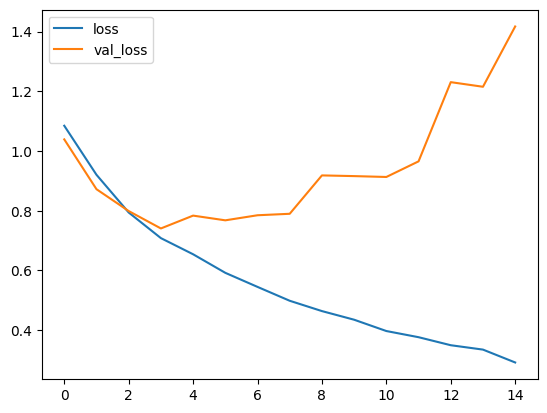

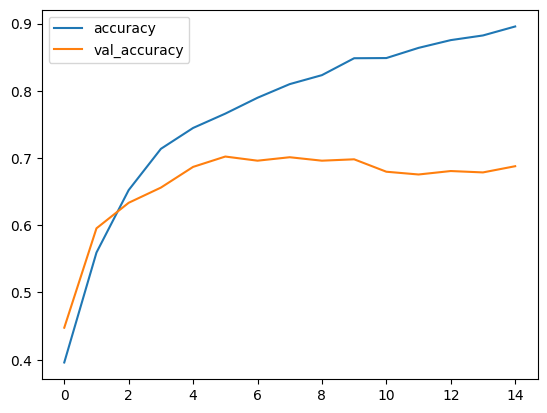

In [14]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
print("\n")
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

predictions = model1.predict(X_valid)
predicted_labels = np.argmax(predictions, axis=1)

accu = accuracy_score(predicted_labels, y_valid)
pre = precision_score(predicted_labels, y_valid,average = "weighted")
f1 = f1_score(predicted_labels, y_valid,average = "weighted")
print("Accuracy:",accu)
print("\nPrecision:",pre)
print("\nF1-Score:",f1)

In [15]:
accu

0.702258726899384

In [16]:
metrics_dict = {}

# Store metrics
metrics_dict['Model 1'] = {'Accuracy': accu, 'Precision': pre, 'F1-Score': f1}

print(metrics_dict)

{'Model 1': {'Accuracy': 0.702258726899384, 'Precision': 0.7035154407604743, 'F1-Score': 0.6996556415727417}}


In [17]:
# Define number of folds
k_folds = 5
# Initialize lists to store results
accuracy_scores = []
precision_scores = []
f1_scores = []

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=50)

# Perform k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[test_index]

    # Create a new instance of the TextVectorization layer and fit it on the training data
    vectorize_layer_fold = tf.keras.layers.TextVectorization(
        max_tokens=max_words,
        output_mode='int',
        output_sequence_length=maxlen
    )
    vectorize_layer_fold.adapt(X_train_fold.values)

    # Clone the model to reset the weights
    model_clone = keras.models.clone_model(model1)

    # Rebuild the model with the new TextVectorization layer
    model_clone = keras.Sequential([
        layers.Input(shape=(1,), dtype=tf.string),
        vectorize_layer_fold,
        layers.Embedding(
            input_dim=max_words,
            output_dim=50,
            input_length=maxlen
        ),
        layers.Bidirectional(layers.GRU(128, return_sequences=True)),
        layers.GlobalMaxPooling1D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax'),
    ])

    model_clone.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model on the current fold
    history_fold = model_clone.fit(X_train_fold, y_train_fold, validation_data=(X_valid_fold, y_valid_fold),
                                    epochs=250, batch_size=60, callbacks = cl, verbose=0)

    # Evaluate the model on the current fold
    predictions_fold = model_clone.predict(X_valid_fold)
    predicted_labels_fold = np.argmax(predictions_fold, axis=1)

    accu_fold = accuracy_score(predicted_labels_fold, y_valid_fold)
    pre_fold = precision_score(predicted_labels_fold, y_valid_fold,average = "weighted")
    f1_fold = f1_score(predicted_labels_fold, y_valid_fold,average = "weighted")

    accuracy_scores.append(accu_fold)
    precision_scores.append(pre_fold)
    f1_scores.append(f1_fold)

31/31 [==============================] - 1s 6ms/step


In [18]:
accuracy_mean = np.mean(accuracy_scores)
accuracy_std = np.std(accuracy_scores)
precision_mean = np.mean(precision_scores)
precision_std = np.std(precision_scores)
f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)

# Print mean and standard deviation
print("Mean Accuracy:", accuracy_mean)
print("Standard Deviation Accuracy:", accuracy_std)
print("Mean Precision:", precision_mean)
print("Standard Deviation Precision:", precision_std)
print("Mean F1-Score:", f1_mean)
print("Standard Deviation F1-Score:", f1_std)

Mean Accuracy: 0.6908977716624003
Standard Deviation Accuracy: 0.010727736013624034
Mean Precision: 0.6971773163144644
Standard Deviation Precision: 0.005759607954608008
Mean F1-Score: 0.6921454704270417
Standard Deviation F1-Score: 0.009282924035975406


In [54]:
accu = accuracy_mean
pre = precision_mean
f1 = f1_std

**RoBERTa**

In [19]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [20]:
train = pd.read_excel("/content/LabeledText.xlsx")

In [21]:
train

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...,...
4864,995.txt,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,996.txt,Feelin' the love in here! #ValentinesDay #caring,positive
4866,997.txt,#blue #eyes can't be #beaten,neutral
4867,998.txt,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


In [22]:
new_df = train[['Caption', 'LABEL']]

In [23]:
new_df

,Caption,LABEL
0,How I feel today #legday #jelly #aching #gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive
3,betterfeelingfilms: RT via Instagram: First da...,neutral
4,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...
4864,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,Feelin' the love in here! #ValentinesDay #caring,positive
4866,#blue #eyes can't be #beaten,neutral
4867,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


In [24]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 5
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [25]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Caption
        self.targets = self.data.LABEL.map({'positive': 0, 'neutral': 1, 'negative': 2})  # Map labels to integers
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Updated padding argument
            truncation= True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)  # Use torch.long for integer targets
        }

In [26]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=150) #200 was here
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [27]:
print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

FULL Dataset: (4869, 2)
TRAIN Dataset: (3895, 2)
TEST Dataset: (974, 2)


In [28]:
training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

In [29]:
training_set

In [30]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [31]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [32]:
model2 = RobertaClass()
model2.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [33]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model2.parameters(), lr=LEARNING_RATE)

In [34]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [35]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model2.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model2(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [36]:
EPOCHS = 2
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Training Loss per 5000 steps: 1.6902427673339844
Training Accuracy per 5000 steps: 0.0


779it [01:47,  7.26it/s]


The Total Accuracy for Epoch 0: 57.61232349165597
Training Loss Epoch: 0.9164192188095985
Training Accuracy Epoch: 57.61232349165597


1it [00:00,  8.28it/s]

Training Loss per 5000 steps: 0.598147988319397
Training Accuracy per 5000 steps: 80.0


779it [01:46,  7.34it/s]

The Total Accuracy for Epoch 1: 74.60847240051348
Training Loss Epoch: 0.608758687360908
Training Accuracy Epoch: 74.60847240051348


In [37]:
predictions_model2 = []

In [38]:
def valid(model, testing_loader):
    model2.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model2(ids, mask, token_type_ids).squeeze()
            predictions_model2.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    print(outputs)

    return epoch_accu

In [39]:
acc = valid(model2, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

2it [00:00, 18.47it/s]

Validation Loss per 100 steps: 0.9087092876434326
Validation Accuracy per 100 steps: 75.0


244it [00:07, 31.77it/s]


Validation Loss Epoch: 0.6748289183301271
Validation Accuracy Epoch: 72.38193018480493
tensor([[-0.0226,  3.0812,  2.5585, -3.6516, -3.6704],
        [ 4.3382,  0.5363, -1.0534, -3.3449, -2.7564]], device='cuda:0')
Accuracy on test data = 72.38%


In [40]:
def evaluate_model(model, testing_loader):
    model.eval()
    predictions_model2 = []
    targets_model2 = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            predictions_model2.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            targets_model2.extend(targets.cpu().numpy())

    f1 = f1_score(targets_model2, predictions_model2, average='weighted')
    precision = precision_score(targets_model2, predictions_model2, average='weighted')
    return f1, precision

f1_model2, precision_model2 = evaluate_model(model2, testing_loader)
print("F1 Score on test data:", f1_model2)
print("Precision on test data:", precision_model2)

244it [00:07, 33.07it/s]

F1 Score on test data: 0.7227094970526254
Precision on test data: 0.7473538736306619


**Model1 vs Model2 Comparison**

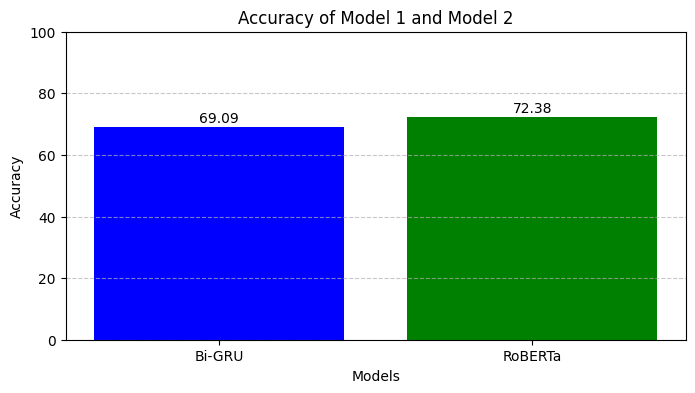

In [75]:
# Plotting accuracies of the two models
models = ['Bi-GRU', 'RoBERTa']
accuracies = [accu*100, acc]

plt.figure(figsize=(8, 4))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Accuracy of Model 1 and Model 2')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.5, str(round(value, 2)), ha='center', va='bottom')
plt.show()

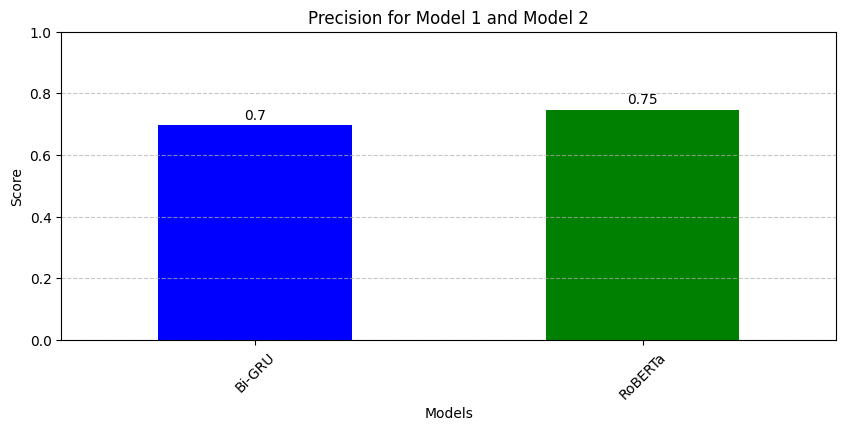

In [82]:
# Data
metrics_dict = {
    'Bi-GRU': {'Precision': pre},
    'RoBERTa': {'Precision': 0.7473538736306619}
}

# Plotting
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
ax = metrics_df.plot(kind='bar', y='Precision', figsize=(10,4), color=["blue","green"], legend=False)
plt.title('Precision for Model 1 and Model 2')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add precision values on top of the bars
for i in ax.patches:
    plt.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, \
             round(i.get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0,1)
plt.show()


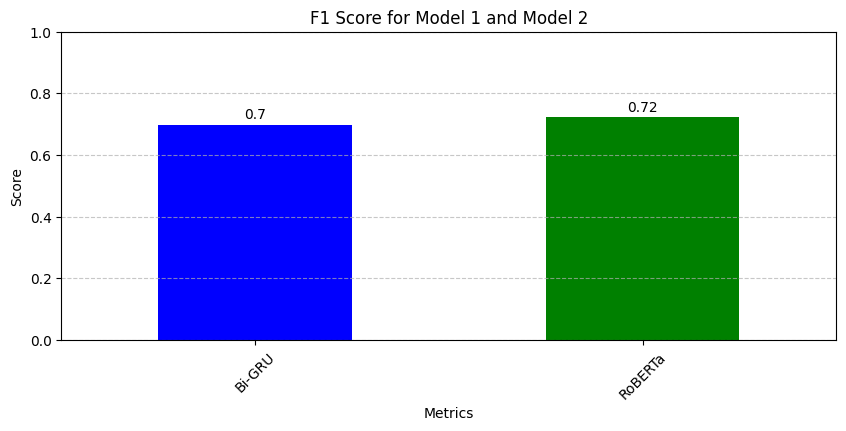

In [86]:
# Data
metrics_dict = {
    'Bi-GRU': {'F1-Score': 0.6988852852917739},
    'RoBERTa': {'F1-Score': 0.7227094970526254}
}

# Plotting
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

ax = metrics_df.plot(kind='bar',y = "F1-Score", figsize=(10,4), color = ['blue',"green"],legend = False)
plt.title('F1 Score for Model 1 and Model 2')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i in ax.patches:
    plt.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, \
             round(i.get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0,1)
plt.show()

**Using Logistic Regression - Ensembling**

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
# Pad predictions_model1 to match the size of predictions_model2
max_samples = max(len(predictions), len(predictions_model2))
padded_predictions_model1 = np.pad(predictions, (0, max_samples - len(predictions)), mode='constant')

# Combine padded predictions into a feature matrix
combined_predictions = np.column_stack((padded_predictions_model1, predictions_model2))

In [45]:
# Adjust target labels to match the size of combined_predictions
y_valid_adjusted = np.pad(y_valid, (0, max_samples - len(y_valid)), mode='constant')

# Train the meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(combined_predictions, y_valid_adjusted)

# Make predictions using the meta-learner
meta_predictions = meta_learner.predict(combined_predictions)

# Evaluate the performance of the meta-learner
meta_accuracy = accuracy_score(y_valid_adjusted, meta_predictions)
print("Meta-Learner Accuracy:", meta_accuracy)

Meta-Learner Accuracy: 0.7063655030800822


In [46]:
meta_precision = precision_score(y_valid_adjusted, meta_predictions, average='weighted')
meta_f1_score = f1_score(y_valid_adjusted, meta_predictions, average='weighted')

# Print ensemble model metrics
print("Precision:", meta_precision)
print("F1-Score:", meta_f1_score)

Precision: 0.7152110392697145
F1-Score: 0.7087311724888592


**Using Gradient Boosting - Ensembling**

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

# Train the meta-learner
meta_learner = GradientBoostingClassifier()
meta_learner.fit(combined_predictions, y_valid_adjusted)

# Make predictions using the meta-learner
meta_predictions = meta_learner.predict(combined_predictions)

# Evaluate the performance of the meta-learner
meta_accuracy = accuracy_score(y_valid_adjusted, meta_predictions)
print("Meta-Learner Accuracy:", meta_accuracy)

# Calculate precision and F1-score for the ensemble model
meta_precision = precision_score(y_valid_adjusted, meta_predictions, average='weighted')
meta_f1_score = f1_score(y_valid_adjusted, meta_predictions, average='weighted')

# Print ensemble model metrics
print("Ensemble Model Metrics:")
print("Accuracy:", meta_accuracy)
print("Precision:", meta_precision)
print("F1-Score:", meta_f1_score)

Meta-Learner Accuracy: 0.8408624229979466
Ensemble Model Metrics:
Accuracy: 0.8408624229979466
Precision: 0.8424246799016268
F1-Score: 0.841335373877623


In [124]:
# Data for plotting
metrics_dict1 = {
    'Bi-GRU': {'Accuracy': accu, 'Precision': pre, 'F1-Score': 0.7},
    'RoBERTa': {'Accuracy': acc/100, 'Precision': precision_model2, 'F1-Score': f1_model2},
    "Logistic Regression":{"Accuracy":0.7063655030800822,"Precision": 0.7152110392697145,"F1-Score":0.7087311724888592},
    'Ensemble Model': {'Accuracy': meta_accuracy, 'Precision': meta_precision, 'F1-Score': meta_f1_score}
}
metrics_dict1

{'Bi-GRU': {'Accuracy': 0.6908977716624003,
  'Precision': 0.6971773163144644,
  'F1-Score': 0.7},
 'RoBERTa': {'Accuracy': 0.7238193018480493,
  'Precision': 0.7473538736306619,
  'F1-Score': 0.7227094970526254},
 'Logistic Regression': {'Accuracy': 0.7063655030800822,
  'Precision': 0.7152110392697145,
  'F1-Score': 0.7087311724888592},
 'Ensemble Model': {'Accuracy': 0.8408624229979466,
  'Precision': 0.8424246799016268,
  'F1-Score': 0.841335373877623}}

<Figure size 1000x600 with 0 Axes>

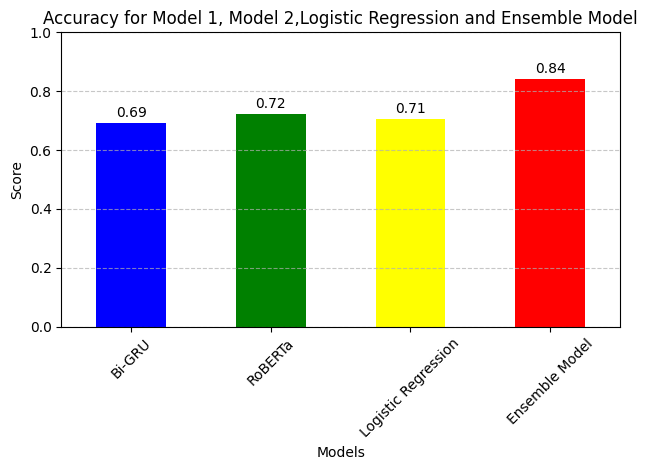

In [122]:
# Create DataFrame from dictionary
metrics_df = pd.DataFrame.from_dict(metrics_dict1, orient='index')

# Plotting
plt.figure(figsize=(10, 6))
ax = metrics_df[["Accuracy"]].plot(kind='bar',y = "Accuracy", color=["blue",'green',"yellow",'red'],legend = False)
plt.title('Accuracy for Model 1, Model 2,Logistic Regression and Ensemble Model')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1-Score values on top of the bars
for i in range(len(ax.patches)):
    plt.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height() + 0.01, \
             round(ax.patches[i].get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

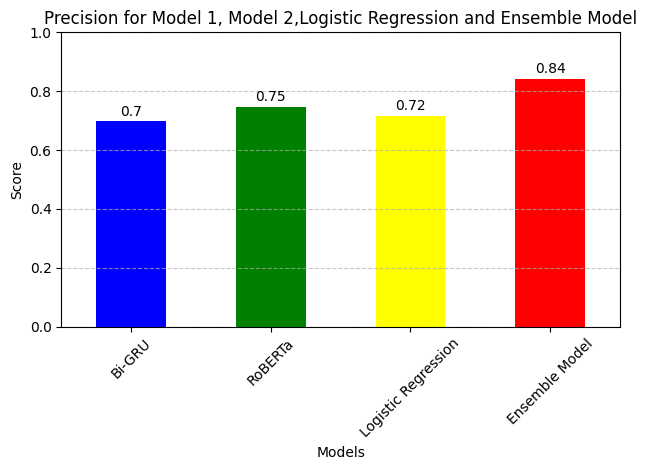

In [121]:
# Create DataFrame from dictionary
metrics_df = pd.DataFrame.from_dict(metrics_dict1, orient='index')

# Plotting
plt.figure(figsize=(10, 6))
ax = metrics_df[["Precision"]].plot(kind='bar',y = "Precision", color=["blue",'green',"yellow",'red'],legend = False)
plt.title('Precision for Model 1, Model 2,Logistic Regression and Ensemble Model')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1-Score values on top of the bars
for i in range(len(ax.patches)):
    plt.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height() + 0.01, \
             round(ax.patches[i].get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

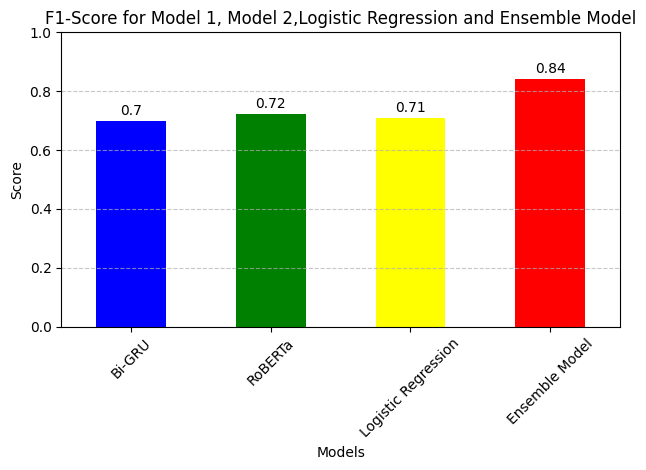

In [125]:
# Create DataFrame from dictionary
metrics_df = pd.DataFrame.from_dict(metrics_dict1, orient='index')

# Plotting
plt.figure(figsize=(10, 6))
ax = metrics_df[["F1-Score"]].plot(kind='bar',y = "F1-Score", color=["blue",'green',"yellow",'red'],legend = False)
plt.title('F1-Score for Model 1, Model 2,Logistic Regression and Ensemble Model')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1-Score values on top of the bars
for i in range(len(ax.patches)):
    plt.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height() + 0.01, \
             round(ax.patches[i].get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [109]:
# Data for plotting
metrics_dict = {
    'Bi-GRU': {'Accuracy': accu, 'Precision': pre, 'F1-Score': 0.7},
    'RoBERTa': {'Accuracy': acc/100, 'Precision': precision_model2, 'F1-Score': f1_model2},
    'Ensemble Model': {'Accuracy': meta_accuracy, 'Precision': meta_precision, 'F1-Score': meta_f1_score}
}
metrics_dict

{'Bi-GRU': {'Accuracy': 0.6908977716624003,
  'Precision': 0.6971773163144644,
  'F1-Score': 0.7},
 'RoBERTa': {'Accuracy': 0.7238193018480493,
  'Precision': 0.7473538736306619,
  'F1-Score': 0.7227094970526254},
 'Ensemble Model': {'Accuracy': 0.8408624229979466,
  'Precision': 0.8424246799016268,
  'F1-Score': 0.841335373877623}}

<Figure size 1000x600 with 0 Axes>

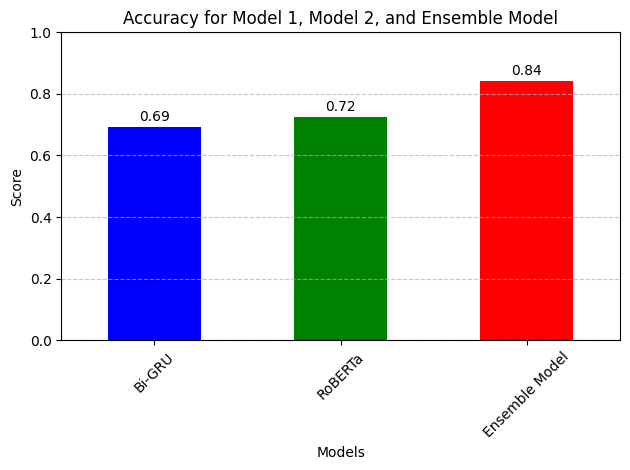

In [112]:
# Create DataFrame from dictionary
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

# Plotting
plt.figure(figsize=(10, 6))
ax = metrics_df[["Accuracy"]].plot(kind='bar',y = "Accuracy", color=["blue",'green','red'],legend = False)
plt.title('Accuracy for Model 1, Model 2, and Ensemble Model')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1-Score values on top of the bars
for i in range(len(ax.patches)):
    plt.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height() + 0.01, \
             round(ax.patches[i].get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

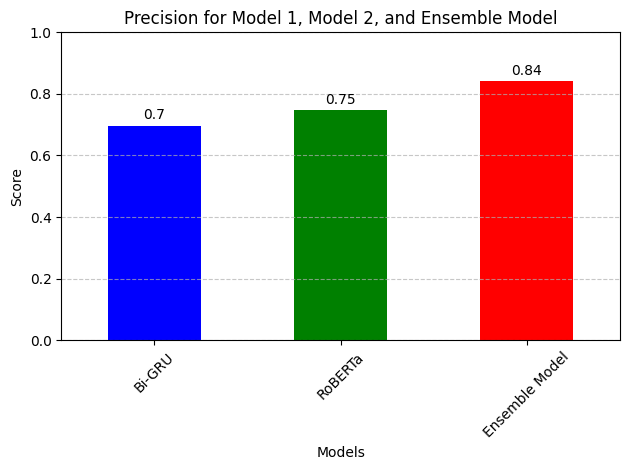

In [104]:
# Create DataFrame from dictionary
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

# Plotting
plt.figure(figsize=(10, 6))
ax = metrics_df[["Precision"]].plot(kind='bar',y = "Precision", color=["blue",'green','red'],legend = False)
plt.title('Precision for Model 1, Model 2, and Ensemble Model')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1-Score values on top of the bars
for i in range(len(ax.patches)):
    plt.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height() + 0.01, \
             round(ax.patches[i].get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

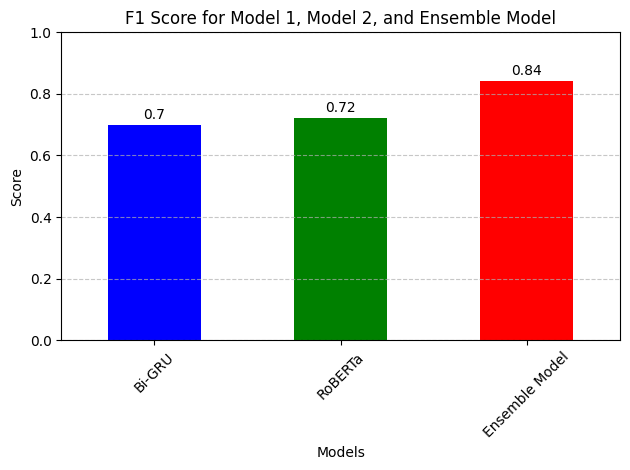

In [102]:
# Create DataFrame from dictionary
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

# Plotting
plt.figure(figsize=(10, 6))
ax = metrics_df[['F1-Score']].plot(kind='bar',y = "F1-Score", color=["blue",'green','red'],legend = False)
plt.title('F1 Score for Model 1, Model 2, and Ensemble Model')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add F1-Score values on top of the bars
for i in range(len(ax.patches)):
    plt.text(ax.patches[i].get_x() + ax.patches[i].get_width() / 2, ax.patches[i].get_height() + 0.01, \
             round(ax.patches[i].get_height(), 2), ha='center', va='bottom', color='black')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [51]:
# Define the path where you want to save the model
model1_path = '/content/drive/MyDrive/model1_bigru'

# Save the model
model1.save(model1_path)

In [52]:
# Define the path where you want to save the model
ensemble_model_path = '/content/drive/MyDrive/ensemble_model'

from joblib import dump

# Define the path where you want to save the model
ensemble_model_path = '/content/drive/MyDrive/ensemble_model.joblib'

# Save the model
dump(meta_learner, ensemble_model_path)

['/content/drive/MyDrive/ensemble_model.joblib']